# Predicting NBA Teams Playoff Chances

This project aims to predict if an NBA team will make the playoffs using a deep neural network. To do this, we use NBA team and opponent's team statistics as our data. Our data starts with the 1979 - 1980 season (the first season with data about the three-point shot) and goes through the 2013 - 2014 season. Twenty percent of the training data is used as validation data. The testing data contains the team statistics from the 2014 - 2015 season to the current season (2019 - 2020).

## Initial Objective
The initial objective of this project was to train a deep neural netowrk to predict the odds of winning a particular playoff series based on the two teams' performance relative to the rest of the league during the regular season. Unfortunately, the results seen were very poor in predicting which teams would face off against one another. Due to this major inaccuracy, the model that predicted more teams that did not actually face off against one another than those that did, in reality, face each other. These reasons are why a revised approach was taken to solely predict which teams would make the playoffs.

In [288]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ai-project-v2/test_set.csv
/kaggle/input/ai-project-v2/AI Project.docx
/kaggle/input/ai-project-v2/training_set.csv
/kaggle/input/ai-project-v2/AI Project Team Stats Data - Master.xlsx


## Features

The features we used are NBA team averages for individual seasons (from 1979 - 1980 to 2013 - 2014) from basketball-reference.com [1].
In this section, we will understand the data we have to work with and see which features are most important and which are least important.

In [289]:
# Read in the data and turn the csv files into DataFrames
test_set = pd.read_csv("/kaggle/input/ai-project-v2/test_set.csv")
training_set = pd.read_csv("/kaggle/input/ai-project-v2/training_set.csv")

# Reset the index of the training set just to be it did not change
training_set.reset_index(inplace = True)

# Make sure the training set loaded correctly
training_set.head()

,index,Season,Team,MP,FG,FGA,FG%,3P,3PA,3P%,...,OORB,ODRB,OTRB,OAST,OSTL,OBLK,OTOV,OPF,OPTS,MADE_PLAYOFFS
0,0,1979-1980,Atlanta Hawks,241.2,39.8,85.7,0.464,0.2,0.9,0.173,...,15.4,28.5,43.9,21.4,8.3,6.8,20.2,26.5,101.6,Y
1,1,1979-1980,Boston Celtics,242.4,44.1,90.1,0.490,2.0,5.1,0.384,...,14.2,28.0,42.2,22.8,8.4,5.1,19.9,25.1,105.7,Y
2,2,1979-1980,Chicago Bulls,242.7,41.0,84.7,0.484,0.9,3.4,0.255,...,14.1,28.6,42.7,25.7,10.3,6.1,18.8,26.9,110.2,N
3,3,1979-1980,Cleveland Cavaliers,243.0,46.5,98.1,0.474,0.4,2.3,0.193,...,15.0,32.2,47.2,26.9,8.6,6.0,20.3,24.8,113.8,N
4,4,1979-1980,Denver Nuggets,241.8,42.2,91.1,0.463,1.0,3.1,0.325,...,14.6,31.5,46.1,27.9,9.9,5.5,17.5,24.8,112.7,N


In [290]:
# Clean up the MADE_PLAYOFFS column from categorical data to numerical data
cleanup = {'MADE_PLAYOFFS': {'Y': 1, 'N': 0}}
training_set.replace(cleanup, inplace = True)
test_set.replace(cleanup, inplace = True)

# Check to see the values were replaced
training_set.head()

,index,Season,Team,MP,FG,FGA,FG%,3P,3PA,3P%,...,OORB,ODRB,OTRB,OAST,OSTL,OBLK,OTOV,OPF,OPTS,MADE_PLAYOFFS
0,0,1979-1980,Atlanta Hawks,241.2,39.8,85.7,0.464,0.2,0.9,0.173,...,15.4,28.5,43.9,21.4,8.3,6.8,20.2,26.5,101.6,1
1,1,1979-1980,Boston Celtics,242.4,44.1,90.1,0.490,2.0,5.1,0.384,...,14.2,28.0,42.2,22.8,8.4,5.1,19.9,25.1,105.7,1
2,2,1979-1980,Chicago Bulls,242.7,41.0,84.7,0.484,0.9,3.4,0.255,...,14.1,28.6,42.7,25.7,10.3,6.1,18.8,26.9,110.2,0
3,3,1979-1980,Cleveland Cavaliers,243.0,46.5,98.1,0.474,0.4,2.3,0.193,...,15.0,32.2,47.2,26.9,8.6,6.0,20.3,24.8,113.8,0
4,4,1979-1980,Denver Nuggets,241.8,42.2,91.1,0.463,1.0,3.1,0.325,...,14.6,31.5,46.1,27.9,9.9,5.5,17.5,24.8,112.7,0


Transforming the MADE_PLAYOFFS column of our data set from a categorical feature to a numerical feature is critical later on when using our deep neural network. In the below segment of code, this column is dropped completely from our test set. Why? As a general rule of thumb for machine learning/deep learning classification problems, the column you are testing should not be in the test set. If our test set had the answers in it, we would not be able to predict those answers, i.e. we would have no problem to solve!

In [291]:
# Drop Made Playoffs column from training set and test set because that is what we are trying to predict
train_X = training_set.drop(columns=['MADE_PLAYOFFS'])
test_X = test_set.drop(columns=['MADE_PLAYOFFS'])

# The categorical features in this data do not add (or remove) any value so we only focus on the numerical data.

numeric_features_list = ['MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 
                 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'OMP', 'OFG', 'OFGA', 'OFG%', 'O3P', 'O3PA', 'O3P%', 
                 'O2P', 'O2PA', 'O2P%', 'OFT', 'OFTA', 'OFT%', 'OORB', 'ODRB', 'OTRB', 'OAST', 'OSTL', 'OBLK', 'OTOV', 'OPTS']
x_data = train_X[numeric_features_list].to_numpy()
# Verify the MADE_PLAYOFFS column was dropped from the training set
train_X.head()

,index,Season,Team,MP,FG,FGA,FG%,3P,3PA,3P%,...,OFT%,OORB,ODRB,OTRB,OAST,OSTL,OBLK,OTOV,OPF,OPTS
0,0,1979-1980,Atlanta Hawks,241.2,39.8,85.7,0.464,0.2,0.9,0.173,...,0.765,15.4,28.5,43.9,21.4,8.3,6.8,20.2,26.5,101.6
1,1,1979-1980,Boston Celtics,242.4,44.1,90.1,0.490,2.0,5.1,0.384,...,0.770,14.2,28.0,42.2,22.8,8.4,5.1,19.9,25.1,105.7
2,2,1979-1980,Chicago Bulls,242.7,41.0,84.7,0.484,0.9,3.4,0.255,...,0.768,14.1,28.6,42.7,25.7,10.3,6.1,18.8,26.9,110.2
3,3,1979-1980,Cleveland Cavaliers,243.0,46.5,98.1,0.474,0.4,2.3,0.193,...,0.765,15.0,32.2,47.2,26.9,8.6,6.0,20.3,24.8,113.8
4,4,1979-1980,Denver Nuggets,241.8,42.2,91.1,0.463,1.0,3.1,0.325,...,0.760,14.6,31.5,46.1,27.9,9.9,5.5,17.5,24.8,112.7


In [292]:
train_Y = training_set[['MADE_PLAYOFFS']]
y_data = train_Y[['MADE_PLAYOFFS']].to_numpy()
y_data = y_data.reshape(y_data.shape[0], )

## Feature Analysis

In the below code segments, the features used are analyzed to show how well they work with our model. It is worth pointing out that the features given are the only features one can work with for this problem because they encapsulate every NBA team statistic.

### Random Forest Regression
First, random forest regression is used to see which features are most significant.

In [293]:
rf_regressor = RandomForestRegressor(n_estimators=200)
rf_regressor.fit(x_data, y_data)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [294]:
sorted_data_significance = np.argsort(rf_regressor.feature_importances_)[::-1]
for index in sorted_data_significance:
    print(f"{numeric_features_list[index]}: {rf_regressor.feature_importances_[index]}")

2P%: 0.19966404326614795
O2P%: 0.17076401391782897
OFG%: 0.04448430756838128
AST: 0.04431641937898035
OPTS: 0.038290724608006185
FT: 0.03603837341136995
STL: 0.03509948286014526
TOV: 0.028570429156179307
OSTL: 0.023228189089587778
OBLK: 0.020066554399686454
OAST: 0.02004839560098367
FT%: 0.01951236266839537
OTOV: 0.017287915475581908
FG%: 0.016236358450408914
3P%: 0.01600532628926914
OTRB: 0.01566103702567355
TRB: 0.015013112064625023
FTA: 0.014935666772869729
FG: 0.01421764750705359
ODRB: 0.014081253263652987
OFG: 0.013760880892425767
O2P: 0.013253392844224865
OFT%: 0.012670873552747451
BLK: 0.012320705860414711
OFT: 0.012063610731658281
DRB: 0.011259682871658934
O3P%: 0.010879328255647865
PF: 0.010699378904570128
OFTA: 0.00957286736311451
FGA: 0.009244083653443704
ORB: 0.008834504118592875
O3PA: 0.008387096767613116
OORB: 0.008148553316190242
3P: 0.007286182808893757
3PA: 0.006981160082613196
MP: 0.006810894077270384
OMP: 0.006666313375514507
O3P: 0.006542597719713575
O2PA: 0.0056895

This shows that using Two Point Shot Percentage gives us the best chance of predicting a team's chances of making the playoffs. Unfortunately, 14 of the features are less than 1% significant. Again, we cannot better this because the features used are the only ones to use.

### Feature Selection

Next, feature selection will show which features are most important. Feature selection is used to see if the significance generated by random forest regression stands true.

In [295]:
feature_selector = SelectKBest(mutual_info_regression, k = 5)
best_feature = feature_selector.fit_transform(x_data, y_data)
sorted_indices = np.argsort(feature_selector.scores_)[::-1]

In [296]:
for index in sorted_indices:
    print(f"{numeric_features_list[index]}: {feature_selector.scores_[index]:.4f}")

2P%: 0.1051
O2P%: 0.0896
FG%: 0.0887
AST: 0.0632
OFT: 0.0560
TRB: 0.0544
O2P: 0.0470
DRB: 0.0458
OFG: 0.0415
OFG%: 0.0408
OBLK: 0.0404
OPTS: 0.0305
FG: 0.0297
OTRB: 0.0286
2PA: 0.0284
O3P: 0.0278
BLK: 0.0276
O3PA: 0.0274
ORB: 0.0273
FT%: 0.0240
ODRB: 0.0237
O3P%: 0.0219
FTA: 0.0211
OFTA: 0.0153
3PA: 0.0151
OTOV: 0.0120
OSTL: 0.0115
FT: 0.0113
3P%: 0.0104
OORB: 0.0098
STL: 0.0093
OAST: 0.0084
TOV: 0.0063
MP: 0.0007
2P: 0.0000
OMP: 0.0000
OFGA: 0.0000
3P: 0.0000
O2PA: 0.0000
FGA: 0.0000
OFT%: 0.0000
PF: 0.0000


In this case, feature selection is in agreement with random forest regrssion. However, it shows that there is not a super strong feature to predict if a team will make the playoffs, but we can only work with the data we have. Compared to random forest regression, the significance/importance of the features is much lower, with eight features having roughly no importance whatsoever.

### Feature Correlation Matrix/Heat Map

By generating a feature correlation matrix/heat map, we can see how each feature correlates with a team making the playoffs. The heat map gives a great visual to better understand the data we have to work with.

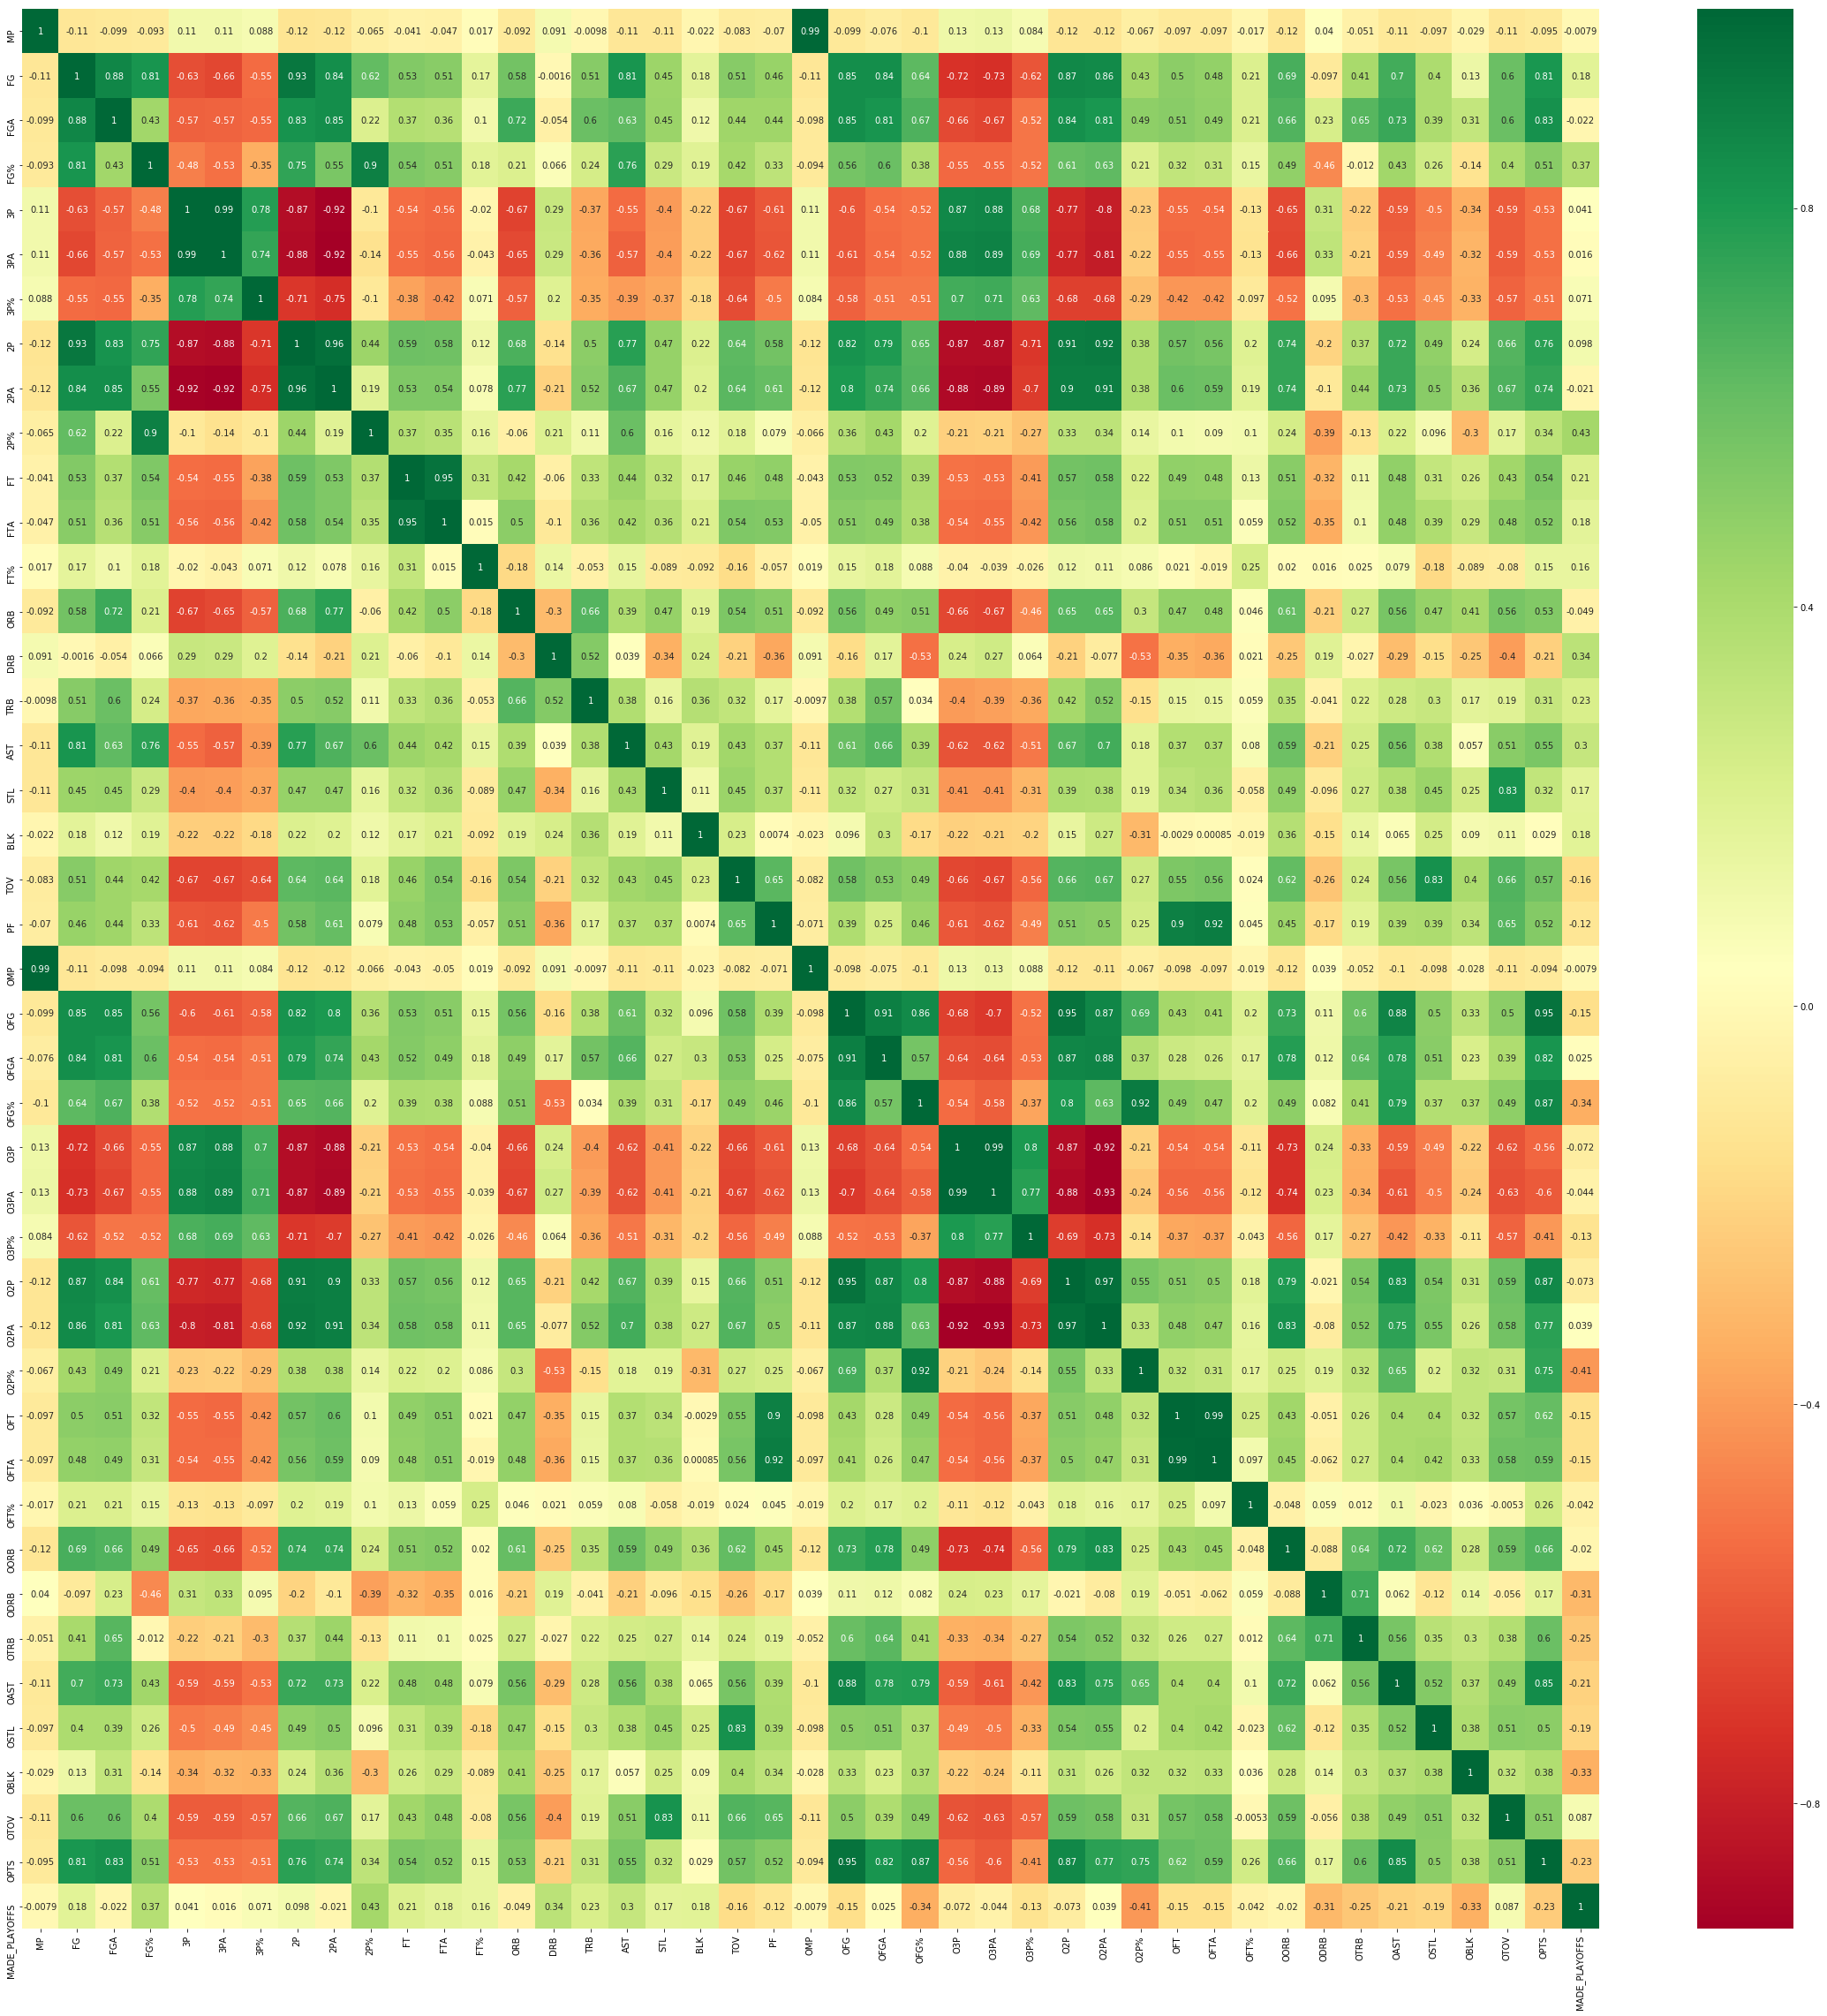

In [297]:
# Create a correlation matrix of the features
data = training_set[numeric_features_list + ["MADE_PLAYOFFS"]]
figure = plt.figure(figsize=(40, 40))
figure.set_facecolor('white')
sns.heatmap(data.corr(), annot=True, cmap="RdYlGn")

With this plot, we can how each feature correlates to making the playoffs.

The following features have a negative correlation with making the playoffs:
- Minutes Played (MP)
- Field Goals Attempted (FGA)
- Two Point Shots Attempted (2PA)
- Offensive Rebounds (ORB)
- Turnovers (TOV)
- Personal Fouls (PF)
- Opponent's Minutes Played (OMP)
- Opponent's Field Goals (OFG)
- Opponent's Field Goal Percentage (OFG%)
- Opponent's Three Point Shots Made (O3P)
- Opponent's Three Point Shots Attempted (O3PA)
- Opponent's Three Point Shot Percentage (O3P%)
- Opponent's Two Point Shots Made (O2P)
- Opponent's Two Point Shot Percentage (O2P%)
- Opponent's Free Throws Made (OFTM)
- Opponent's Free Throws Attempted (OFTA)
- Opponent's Free Throw Percentage (OFT%)
- Opponent's Offensive Rebounds (OORB)
- Opponent's Defensive Rebounds (ODRB)
- Opponent's Total Rebounds (OTRB)
- Opponent's Assists (OAST)
- Opponent's Steals (OSTL)
- Opponent's Blocks (OBLK)
- Opponent's Points (OPTS)

Does this make sense? Absolutely! A team's opponent's statistics will always have a negative correlation on the team's chances to make the playoffs. Specifically, this correlation matrix shows that the opponent's two point shot percentage, opponent's field goal percentage, opponent's blocks, and opponent's defensive rebounds correlate strongest with a team's chances of not making the playoffs. It also makes sense that the minutes played by a team and their opponents has no effect on if a team makes the playoffs. At -0.0079, minutes played (MP) and opponent's minutes played (OMP) can essentially be viewed as a non-determinant. For the team's features that correlated negatively, here is a possible explanation why:
- *Field Goals Attempted: The more shots a team attempts per game will increase their chances of making the playoffs if those shots go in, but if they do not go in their chances of making the playoffs decrease. At -0.022, this feature could also be seen as a non-determinant, but it is worth pointing out the slight negative correlation.
- Two Point Shots Attempted: Same explation as Field Goals Attempted, but just for two point shots. At -0.021, this feature could also be seen as a non-determinant, but it is worth pointing out the slight negative correlation.
- Offensive Rebounds: According to Jeff Haefner [1], the average offensive rebounding percentage in the NBA only makes up 27% of total rebounds. Seeing that about every one and four rebounds is an offensive rebound, it makes sense that a team's offensive rebounds do not matter much for making the playoffs.
- Turnovers: Turnovers are seen as a negative for a team. The more they turn the ball over, the less opportunities they have to score. By having less opportunities to score, and therefore win games, it will be harder to make the playoffs.
- Personal Fouls: Similar to turnovers, personal fouls are not seen as a positive for a team. Fouls mess up the flow of a game and can give impact players less playing time per a particular game. Fouls have a huge impact on the individual game and therefore have an impact on a team's chances of making the playoffs.

## Deep Neural Network

In this section we create our deep neural network. 

### Model Creation
The model is created using keras [3].

#### Layers
The model contains three layers, two rectified linear unit (ReLU) activation layers and a final sigmoid activation layer. Why ReLU activation for the first two layers? In my Artificial Intelligence class, we learned that using ReLU will achieve better performance over sigmoid and hyperbolic tangent activation functions. This logic does not just follow what we learned in class, but also holds true within the general AI community.

Why sigmoid activation for the last layer? A sigmoid function will only give values between 0 and 1. This is exactly what we want when trying to predict the chance (or probability) an NBA team will make the playoffs. We also use a sigmoid function for the output layer because we choose a binary cross entropy (BCE) loss function. Keep reading for more about the BCE loss function.

In [298]:
# Create model using keras
model = Sequential()

# Get the number of columns in the training data
n_cols = x_data.shape[1]

# Add layers to the model
model.add(Dense(20, activation='relu', input_shape=(n_cols,)))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

### Compiling the Model

When we compile a model, we need to specify the loss function, the optimizer, and any metrics we are looking to gain insight on.

For this model, the loss function chosen is BCE. Cross entropy calculates a score that summarizes the average difference between the actual and predicted probability distributions for predicting class 1. The score is minimized and a perfect cross-entropy value is 0 [4]. The optimizer used is adam. From my research, adam is a very efficient stochastic gradient descent algorithm that works well for a vast amount of classification problems. It can also tune itself. The metric we are after is accuracy. We want to know how accurate the classification is.

In [299]:
# Compile the model using binary cross entropy and the adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Training the Model

In our training, we split twenty percent of the training data into validation data and use 100 epochs. An epoch is defined as one pass through all the rows in the training set. Due to the nature of .ipynb files, each epoch is not shown, but since the code segment runs successfully, we can be sure each epoch did successfully run.

In [300]:
# Train the model using the early stopping monitor so we won't waste any effort trying to improve the model 
# when it won't improve anymore.
# If the model does not improve, we will stop training.
early_stopping_monitor = EarlyStopping(patience = 3)

# Train the model
model.fit(x_data, y_data, validation_split = 0.2, epochs = 100, callbacks=[early_stopping_monitor])

# Training the model on x_data (which only contains numerical data) and comparing it to test_X which has 
# every column except for MADE_PLAYOFFS.
test_X = test_X[numeric_features_list].to_numpy()

Train on 750 samples, validate on 188 samples
Epoch 1/100
750/750 [==============================] - 0s 280us/step - loss: 7.1441 - accuracy: 0.5160 - val_loss: 1.3677 - val_accuracy: 0.4362
Epoch 2/100
750/750 [==============================] - 0s 57us/step - loss: 1.6594 - accuracy: 0.4587 - val_loss: 1.7079 - val_accuracy: 0.4628
Epoch 3/100
750/750 [==============================] - 0s 54us/step - loss: 1.1390 - accuracy: 0.4547 - val_loss: 1.0288 - val_accuracy: 0.3883
Epoch 4/100
750/750 [==============================] - 0s 57us/step - loss: 1.0433 - accuracy: 0.4787 - val_loss: 1.1591 - val_accuracy: 0.4574
Epoch 5/100
750/750 [==============================] - 0s 55us/step - loss: 0.9700 - accuracy: 0.4587 - val_loss: 0.9723 - val_accuracy: 0.4415
Epoch 6/100
750/750 [==============================] - 0s 56us/step - loss: 0.9457 - accuracy: 0.4627 - val_loss: 0.9942 - val_accuracy: 0.4415
Epoch 7/100
750/750 [==============================] - 0s 57us/step - loss: 0.9888 - accu

In [301]:
# Evaluate the model's accuracy on the training set
_, train_accuracy = model.evaluate(x_data, y_data)
print("Accuracy: %.3f" % (train_accuracy * 100) + "%")

938/938 [==============================] - 0s 25us/step
Accuracy: 63.113%


Unfortunately, the model's accuracy on the training set is not very high. After running it five times, the accuracy seen is as follows:

Accuracy of Runs  
1: 58.316%    
2: 46.588%    
3: 65.458%    
4: 75.693%    
5: 63.113%

The range of percent accuracy is ~ 29%. Therefore, the results we get should be taken with a grain of salt.

### Model Predictions

Finally, time for the results! Let's see how well our model performed.

In [302]:
# Make predictions
test_y_predictions = model.predict(test_X)
rounded_predictions = [round(index[0]) for index in test_y_predictions]

In [303]:
# Print our predictions
for index in range(len(test_y_predictions)):
    print(f"{test_set['Season'][index]} {test_set['Team'][index]}: {int(rounded_predictions[index])} Expected: {test_set['MADE_PLAYOFFS'][index]}")

2013-2014 Memphis Grizzlies: 0 Expected: 1.0
2013-2014 Miami Heat: 1 Expected: 1.0
2013-2014 Milwaukee Bucks: 0 Expected: 0.0
2013-2014 Minnesota Timberwolves: 1 Expected: 0.0
2013-2014 New Orleans Pelicans: 1 Expected: 0.0
2013-2014 New York Knicks: 1 Expected: 0.0
2013-2014 Oklahoma City Thunder: 1 Expected: 1.0
2013-2014 Orlando Magic: 0 Expected: 0.0
2013-2014 Philadelphia 76ers: 0 Expected: 0.0
2013-2014 Phoenix Suns: 1 Expected: 0.0
2013-2014 Portland Trail Blazers: 1 Expected: 1.0
2013-2014 Sacramento Kings: 1 Expected: 0.0
2013-2014 San Antonio Spurs: 1 Expected: 1.0
2013-2014 Toronto Raptors: 1 Expected: 1.0
2013-2014 Utah Jazz: 0 Expected: 0.0
2013-2014 Washington Wizards: 1 Expected: 1.0
2014-2015 Atlanta Hawks: 1 Expected: 1.0
2014-2015 Boston Celtics: 0 Expected: 1.0
2014-2015 Brooklyn Nets: 1 Expected: 1.0
2014-2015 Charlotte Hornets: 1 Expected: 0.0
2014-2015 Chicago Bulls: 1 Expected: 1.0
2014-2015 Cleveland Cavaliers: 1 Expected: 1.0
2014-2015 Dallas Mavericks: 1 Expec

For the 16 teams in the 2013 - 2014 season, our model made the correct prediction for 10 teams (62.50% correct)
The rest of the seasons include every team.
For the 2014 - 2015 season, our model made the correct prediction for 17 teams (56.67% correct)
For the 2015 - 2016 season, our model made the correct prediction for 22 teams (73.33% correct)
For the 2016 - 2017 season, our model made the correct prediction for 23 teams (76.67% correct)
For the 2017 - 2018 season, our model made the correct prediction for 24 teams (80.00% correct)
For the 2018 - 2019 season, our model made the correct prediction for 22 teams (73.33% correct)

The 2019 - 2020 season is still underway but based on the current regular season statistics for every team, our model predicts based off of the games played so far, ten teams will not make the playoffs. This result most likely would change once more games are played. As of December 23rd, 2019, the ten teams our model predicted to not make the playoffs all have a losing record (more losses than wins).

## Analysis of Results

The results our model achieved are not great, but they are certainly not awful. The model has a propensity for teams making the playoffs versus not making the playoffs. Why might this be?

One possible explanation is because most NBA games are competitive. Seeing a blowout every night is unlikely to happen. Based solely on statistics and not factoring in a team's regular season wins and losses, it is very hard to predict which teams will and will not make the playoffs. Think about it this way: If team A and team B both average the same statistics (offensively and defensively), team A might have a record of 50 wins and 32 losses and team B could have a record of 32 losses and 50 wins. In this case, team A is much more likely to make the playoffs than team B given their win-loss records, but they have an equal likelihood of making the playoffs given their statistics. If wins and losses were factored in, our model could easily predict which teams would make the playoffs because wins and losses hold the most weight in determining that.

While the results do not very accurately predict which teams will make the playoffs, the results make sense given the data.

# References

[1] Anon. NBA & ABA League Index. Retrieved November 19, 2019 from https://www.basketball-reference.com/leagues/

[2] Jeff Haefner. Why Every Basketball Coach Should Look at Rebounding Percentage Instead of Totals. Retrieved December 19, 2019 from https://www.breakthroughbasketball.com/stats/rebounding-stats.html

[3] François Challot and others. Keras. Github. 2015

[4] Jason Brownlee. 2019. Your First Deep Learning Project in Python with Keras Step-By-Step. (October 2019). Retrieved December 19, 2019 from https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/